In [1]:
#Практична робота 9. Приклад побудови нейромережі tensorflow для датасета mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28*28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальна кількість епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковому підтримці з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат та точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from tensorflow.keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, що складається із 128 нейронів.
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар, що складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)

    # Пам'ятайте, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
    # Робимо ми це для того, щоб
    # вихід нейронної мережі приймав значення від 0 до 1 відповідно до ймовірності
    # Приналежності вхідного об'єкта до одного з 10 класів

    return x3

In [5]:
# Як функцію помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Створимо список параметрів, що оптимізуються.
    trainable_variables = nn.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)
    
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігайте в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігайте в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# з тренувального датасету train_data вийміть випадкову підмножину, на якій
# відбудеться тренування. Використовуйте метод take, доступний для тренувального датасету.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)
        
        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 2633.0380859375, Accuracy: 0.11328125
Step: 100, Loss: 285.92755126953125, Accuracy: 0.671875
Step: 200, Loss: 255.63412475585938, Accuracy: 0.65625
Step: 300, Loss: 233.4666748046875, Accuracy: 0.71875
Step: 400, Loss: 197.08810424804688, Accuracy: 0.75390625
Step: 500, Loss: 261.8914794921875, Accuracy: 0.73046875
Step: 600, Loss: 170.3412628173828, Accuracy: 0.7890625
Step: 700, Loss: 139.71817016601562, Accuracy: 0.82421875
Step: 800, Loss: 193.51779174804688, Accuracy: 0.72265625
Step: 900, Loss: 140.1701202392578, Accuracy: 0.80859375
Step: 1000, Loss: 161.31161499023438, Accuracy: 0.78125
Step: 1100, Loss: 189.5245361328125, Accuracy: 0.7578125
Step: 1200, Loss: 140.2412109375, Accuracy: 0.78125
Step: 1300, Loss: 111.75848388671875, Accuracy: 0.82421875
Step: 1400, Loss: 140.81558227539062, Accuracy: 0.79296875
Step: 1500, Loss: 151.07656860351562, Accuracy: 0.7890625
Step: 1600, Loss: 153.69203186035156, Accuracy: 0.78515625
Step: 1700, Loss: 132.76858520507812, 

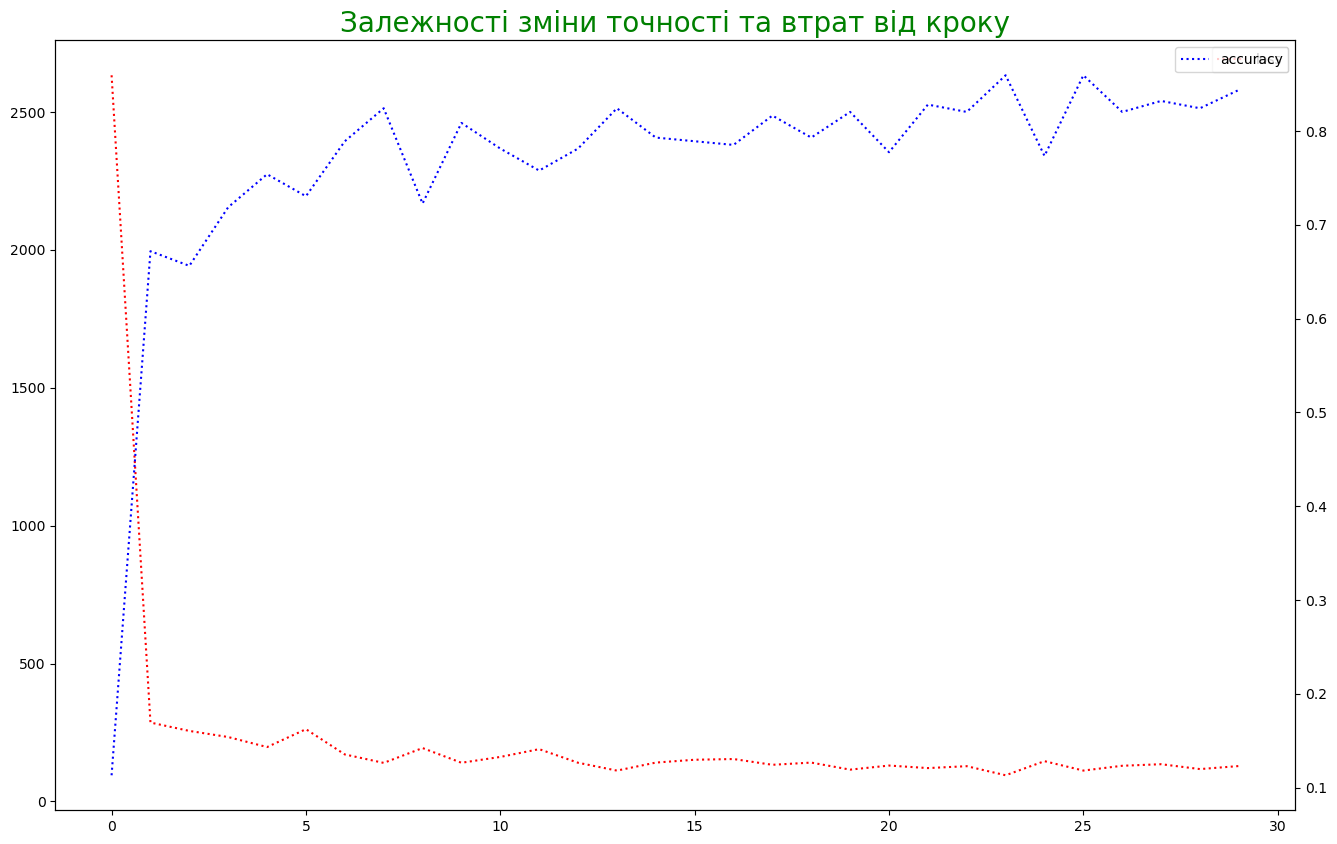

In [8]:
# Виведіть графіки залежності зміни точності та втрат від кроку
# Якщо все зроблено правильно, то точність має зростати, а втрати зменшуватися

import pandas as pd

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

In [9]:
# Обчисліть точність навченої нейромережі

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.8168500065803528


True: 3 Predict: 3 True
True: 6 Predict: 6 True
True: 6 Predict: 8 False
True: 7 Predict: 7 True
True: 5 Predict: 5 True
True: 2 Predict: 2 True
True: 5 Predict: 5 True
True: 6 Predict: 6 True
True: 5 Predict: 5 True
True: 1 Predict: 1 True


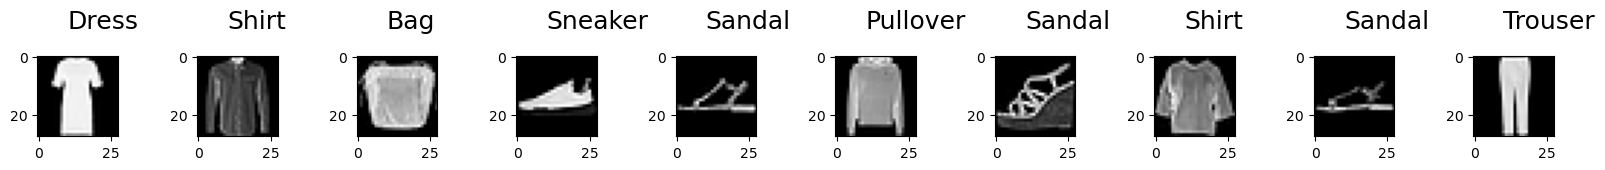

In [13]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється ваша нейронна мережа і якщо так, то як часто?
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=class_names[pred_data[i]], fontsize=18)
    
plt.tight_layout()
plt.show()

In [ ]:
# Увесь одяг було вказано вірно.